# of good matches: 680


/tmp/ipykernel_2095181/1303918611.py:35: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('hsv', len(matches))


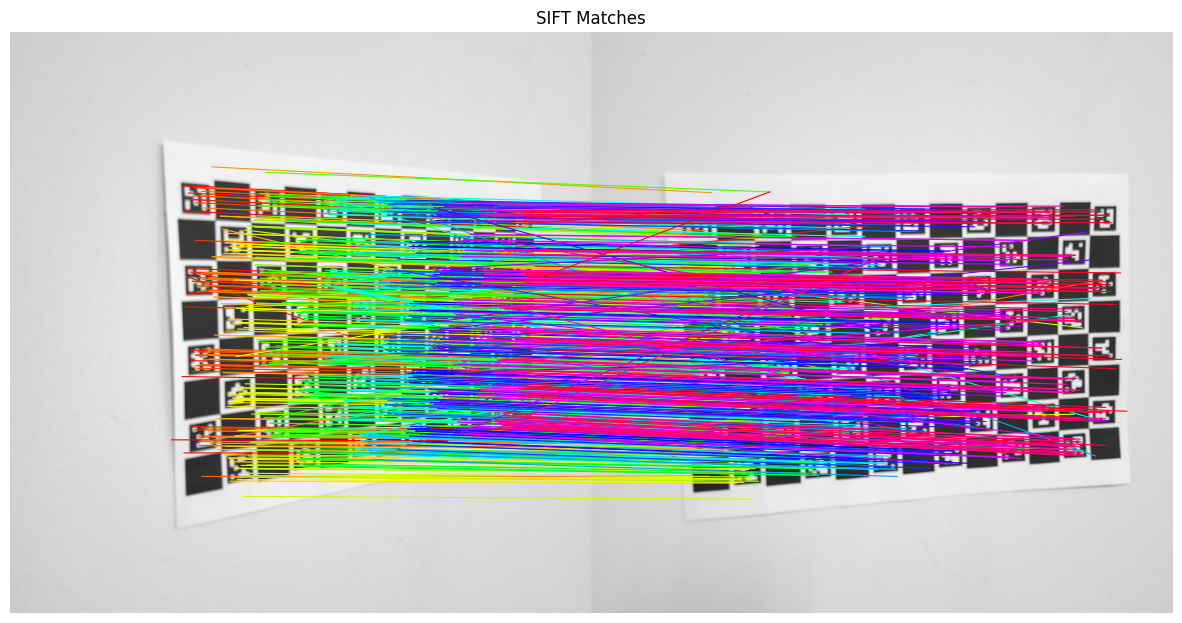

In [2]:
from pathlib import Path
import cv2
import numpy as np
import matplotlib.pyplot as plt

def sift_match(img1, img2, ratio_thresh=0.75):
    sift = cv2.SIFT_create()

    # Step 1: Detect and compute descriptors
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)

    # Step 2: Brute-Force Matcher with L2 norm
    bf = cv2.BFMatcher()
    raw_matches = bf.knnMatch(des1, des2, k=2)

    # Step 3: Lowe's ratio test
    good_matches = []
    for m, n in raw_matches:
        if m.distance < ratio_thresh * n.distance:
            good_matches.append((kp1[m.queryIdx].pt, kp2[m.trainIdx].pt))

    return good_matches, kp1, kp2

def draw_sift_matches(img1, img2, matches):
    h1, w1 = img1.shape
    h2, w2 = img2.shape
    canvas = np.zeros((max(h1, h2), w1 + w2), dtype=np.uint8)
    canvas[:h1, :w1] = img1
    canvas[:h2, w1:] = img2

    plt.figure(figsize=(15, 10))
    plt.imshow(canvas, cmap='gray')

    cmap = plt.cm.get_cmap('hsv', len(matches))

    for i, ((x1, y1), (x2, y2)) in enumerate(matches):
        color = cmap(i)
        plt.plot([x1, x2 + w1], [y1, y2], color=color, linewidth=0.8)
    plt.title("SIFT Matches")
    plt.axis('off')
    plt.show()

IMAGE_DIR = Path('camera_images3')

img1 = cv2.imread(IMAGE_DIR / '0.jpeg', cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread(IMAGE_DIR / '1.jpeg', cv2.IMREAD_GRAYSCALE)

matches, kp1, kp2 = sift_match(img1, img2)
print(f"# of good matches: {len(matches)}")

draw_sift_matches(img1, img2, matches)

In [3]:
def compute_homography(matches):
    A = []
    for (x, y), (xp, yp) in matches:
        A.append([-x, -y, -1, 0, 0, 0, x*xp, y*xp, xp])
        A.append([0, 0, 0, -x, -y, -1, x*yp, y*yp, yp])
    A = np.array(A)

    # SVD
    U, S, Vt = np.linalg.svd(A)
    h = Vt[-1, :]
    H = h.reshape(3, 3)
    return H / H[2, 2]

def average_reprojection_error(matches, H):
    total_error = 0
    for (x, y), (xp, yp) in matches:
        p = np.array([x, y, 1.0])
        projected = H @ p
        projected /= projected[2]
        error = np.linalg.norm(projected[:2] - np.array([xp, yp]))
        total_error += error
    return total_error / len(matches)

H = compute_homography(matches)
error = average_reprojection_error(matches, H)
print(f"Average Reprojection Error: {error:.4f} pixels")

Average Reprojection Error: 2249.2821 pixels


RANSAC Homography Inliers: 331 / 680
Average Reprojection Error after RANSAC: 1.7784 pixels


/tmp/ipykernel_2095181/1303918611.py:35: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('hsv', len(matches))


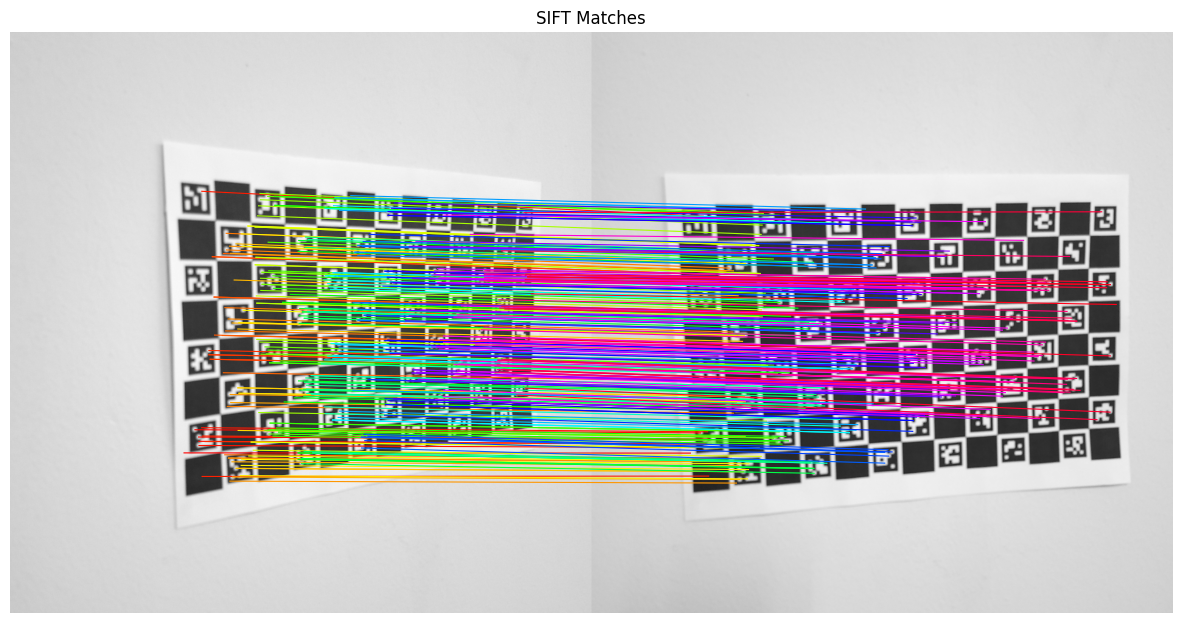

In [4]:
import random

def ransac_homography(matches, threshold=3.0, iterations=1000):
    best_H = None
    max_inliers = 0
    best_inliers = []

    for _ in range(iterations):
        sample = random.sample(matches, 4)
        H_candidate = compute_homography(sample)
        inliers = []

        for (x, y), (xp, yp) in matches:
            p = np.array([x, y, 1.0])
            projected = H_candidate @ p
            projected /= projected[2]
            error = np.linalg.norm(projected[:2] - np.array([xp, yp]))
            if error < threshold:
                inliers.append(((x, y), (xp, yp)))

        if len(inliers) > max_inliers:
            max_inliers = len(inliers)
            best_H = H_candidate
            best_inliers = inliers

    return best_H, best_inliers

H_ransac, inlier_matches = ransac_homography(matches, threshold=3.0, iterations=1000)
error = average_reprojection_error(inlier_matches, H_ransac)

print(f"RANSAC Homography Inliers: {len(inlier_matches)} / {len(matches)}")
print(f"Average Reprojection Error after RANSAC: {error:.4f} pixels")

draw_sift_matches(img1, img2, inlier_matches)

In [5]:
# 여러 이미지에 대해 Homography 계산
import os

filenames = sorted(os.listdir(IMAGE_DIR))
H_list = []

# 기준 카메라: 0th image
img0_path = IMAGE_DIR / filenames[0]
img0 = cv2.imread(img0_path, cv2.IMREAD_GRAYSCALE)

for i in range(1, len(filenames)):
    img_path = IMAGE_DIR / filenames[i]
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    
    matches, kp1, kp2 = sift_match(img0, img)
    print(f"Matching image0 and image{i}: {len(matches)} good matches")

    H_ransac, inlier_matches = ransac_homography(matches, threshold=3.0, iterations=1000)
    error = average_reprojection_error(inlier_matches, H_ransac)

    H_list.append(H_ransac)

    print(f"RANSAC Homography for image0 and image{i}:")
    print(f"Inliers: {len(inlier_matches)} / {len(matches)}")
    print(f"Average Reprojection Error: {error:.4f} pixels\n")

Matching image0 and image1: 680 good matches
RANSAC Homography for image0 and image1:
Inliers: 336 / 680
Average Reprojection Error: 1.7305 pixels

Matching image0 and image2: 671 good matches
RANSAC Homography for image0 and image2:
Inliers: 483 / 671
Average Reprojection Error: 1.4181 pixels

Matching image0 and image3: 810 good matches
RANSAC Homography for image0 and image3:
Inliers: 589 / 810
Average Reprojection Error: 1.6166 pixels

Matching image0 and image4: 530 good matches
RANSAC Homography for image0 and image4:
Inliers: 225 / 530
Average Reprojection Error: 1.6687 pixels

Matching image0 and image5: 558 good matches
RANSAC Homography for image0 and image5:
Inliers: 223 / 558
Average Reprojection Error: 1.6067 pixels

Matching image0 and image6: 531 good matches
RANSAC Homography for image0 and image6:
Inliers: 179 / 531
Average Reprojection Error: 1.7475 pixels

Matching image0 and image7: 527 good matches
RANSAC Homography for image0 and image7:
Inliers: 255 / 527
Average

In [6]:
def compute_v_ij(H, i, j):
    return np.array([
        H[0, i]*H[0, j],
        H[0, i]*H[1, j] + H[1, i]*H[0, j],
        H[1, i]*H[1, j],
        H[2, i]*H[0, j] + H[0, i]*H[2, j],
        H[2, i]*H[1, j] + H[1, i]*H[2, j],
        H[2, i]*H[2, j]
    ])

def estimate_intrinsics(H_list):
    V = []
    for H in H_list:
        v12 = compute_v_ij(H, 0, 1)
        v11 = compute_v_ij(H, 0, 0)
        v22 = compute_v_ij(H, 1, 1)
        V.append(v12)
        V.append(v11 - v22)
    V = np.array(V)

    # Solve Vb = 0 using SVD
    _, _, Vt = np.linalg.svd(V)
    b = Vt[-1, :]

    # Extract parameters from b
    B11, B12, B22, B13, B23, B33 = b
    v0 = (B12*B13 - B11*B23) / (B11*B22 - B12**2)
    lam = B33 - (B13**2 + v0*(B12*B13 - B11*B23)) / B11
    alpha = np.sqrt(lam / B11)
    beta = np.sqrt(lam * B11 / (B11*B22 - B12**2))
    gamma = -B12 * alpha**2 * beta / lam
    u0 = gamma * v0 / beta - B13 * alpha**2 / lam

    # Construct K matrix
    K = np.array([
        [alpha, gamma, u0],
        [0,     beta,  v0],
        [0,     0,     1]
    ])
    return K

def estimate_extrinsics(H, K):
    K_inv = np.linalg.inv(K)
    h1 = H[:, 0]
    h2 = H[:, 1]
    h3 = H[:, 2]

    lambda_ = 1.0 / np.linalg.norm(K_inv @ h1)
    r1 = lambda_ * (K_inv @ h1)
    r2 = lambda_ * (K_inv @ h2)
    r3 = np.cross(r1, r2)
    t = lambda_ * (K_inv @ h3)

    # Ensure R is a valid rotation matrix using orthonormalization (SVD)
    R = np.stack([r1, r2, r3], axis=1)
    U, _, Vt = np.linalg.svd(R)
    R_orthonormal = U @ Vt

    return R_orthonormal, t

def is_valid_homography(H, cond_thresh=1e6):
    return (
        np.isfinite(H).all() and 
        np.abs(H[2, 2] - 1.0) < 1e-3 and 
        np.linalg.cond(H) < cond_thresh
    )

def estimate_extrinsics_safe(H_list, K, cond_thresh=1e8):
    extrinsics = []
    for i, H in enumerate(H_list):
        if not is_valid_homography(H, cond_thresh):
            print(f"⚠️ Skipping H[{i}] due to high condition number: {np.linalg.cond(H):.2e}")
            continue
        try:
            R, t = estimate_extrinsics(H, K)
            if R is not None:
                extrinsics.append((R, t))
        except np.linalg.LinAlgError:
            print(f"⚠️ SVD failed for H[{i}]")
    return extrinsics

K = estimate_intrinsics(H_list)
print("Estimated Intrinsic Matrix K:\n", K)

# First camera's extrinsics (identity for the first camera)
extrinsics = [(np.eye(3), np.zeros(3))]

# Append the extrinsics for the other cameras
for idx, H in enumerate(H_list):
    if idx == 0:
        continue  # Skip the first camera
    R, t = estimate_extrinsics(H, K)
    print(f"Image {idx+2}:")
    print("Rotation Matrix R:\n", R)
    print("Translation Vector t:\n", t)
    print()
    extrinsics.append((R, t))


Estimated Intrinsic Matrix K:
 [[ 2.31040849e+03  3.03519074e+01 -3.85799324e+02]
 [ 0.00000000e+00  2.30729432e+03  1.45196391e+03]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Image 3:
Rotation Matrix R:
 [[ 0.98936472 -0.10730761 -0.09819635]
 [ 0.12180972  0.98019631  0.15613324]
 [ 0.07949742 -0.16643398  0.98284276]]
Translation Vector t:
 [  630.0438023  -1790.75932637  2681.846613  ]

Image 4:
Rotation Matrix R:
 [[ 0.99481112 -0.08730187  0.05224192]
 [ 0.07871435  0.98578363  0.14844087]
 [-0.06445839 -0.14355844  0.98754042]]
Translation Vector t:
 [  142.69285207 -1604.94033224  2488.38461581]

Image 5:
Rotation Matrix R:
 [[ 0.89689881 -0.15521327  0.41410309]
 [ 0.06070138  0.97073023  0.23237503]
 [-0.43805008 -0.18328026  0.88006845]]
Translation Vector t:
 [  330.95987276 -1697.22240248  3353.02076496]

Image 6:
Rotation Matrix R:
 [[ 0.54156331 -0.1818921   0.82074627]
 [-0.0049952   0.97559833  0.21950614]
 [-0.84064513 -0.12297627  0.52743967]]
Translation Ve

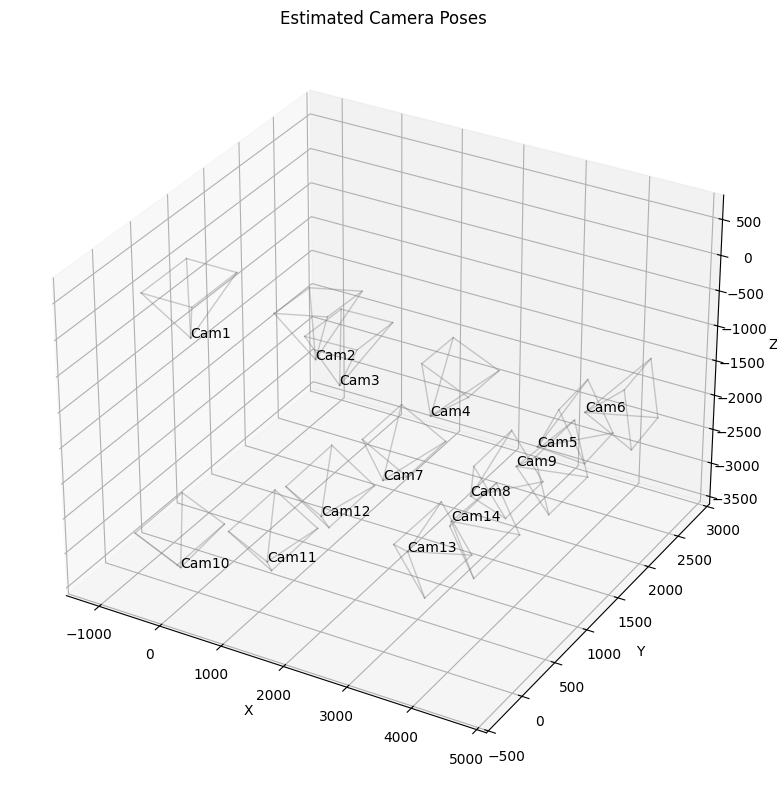

In [7]:
from mpl_toolkits.mplot3d import Axes3D

def plot_camera_frustum(ax, R, camera_center, scale):
    """
    카메라 프러스텀(시야각)을 시각화하는 함수
    """
    # 프러스텀 크기
    frustum_length = scale * 1.5
    frustum_width = scale * 0.8
    frustum_height = scale * 0.6
    
    # 프러스텀 모서리 점들 (카메라 좌표계에서)
    frustum_points_local = np.array([
        [0, 0, 0],  # 카메라 중심
        [-frustum_width, -frustum_height, frustum_length],  # 좌하
        [frustum_width, -frustum_height, frustum_length],   # 우하
        [frustum_width, frustum_height, frustum_length],    # 우상
        [-frustum_width, frustum_height, frustum_length]    # 좌상
    ])
    
    # 월드 좌표계로 변환
    frustum_points_world = []
    for point in frustum_points_local:
        world_point = R @ point + camera_center
        frustum_points_world.append(world_point)
    
    frustum_points_world = np.array(frustum_points_world)
    
    # 프러스텀 선 그리기
    # 카메라 중심에서 각 모서리로
    for i in range(1, 5):
        ax.plot([frustum_points_world[0, 0], frustum_points_world[i, 0]],
                [frustum_points_world[0, 1], frustum_points_world[i, 1]],
                [frustum_points_world[0, 2], frustum_points_world[i, 2]], 
                'gray', alpha=0.4, linewidth=1)
    
    # 프러스텀 사각형 그리기
    for i in range(1, 5):
        next_i = i + 1 if i < 4 else 1
        ax.plot([frustum_points_world[i, 0], frustum_points_world[next_i, 0]],
                [frustum_points_world[i, 1], frustum_points_world[next_i, 1]],
                [frustum_points_world[i, 2], frustum_points_world[next_i, 2]], 
                'gray', alpha=0.4, linewidth=1)

# Visualize camera extrinsics in 3D space
def plot_camera_poses(K, extrinsics):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # World coordinate axes
    ax.quiver(0, 0, 0, 1, 0, 0, color='r', length=0.5)
    ax.quiver(0, 0, 0, 0, 1, 0, color='g', length=0.5)
    ax.quiver(0, 0, 0, 0, 0, 1, color='b', length=0.5)

    for idx, (R, t) in enumerate(extrinsics):
        # Camera center in world coordinates
        C = -R.T @ t

        # Draw camera axis
        cam_axis = R.T
        ax.quiver(C[0], C[1], C[2], cam_axis[0, 0], cam_axis[1, 0], cam_axis[2, 0], color='r', length=0.3)
        ax.quiver(C[0], C[1], C[2], cam_axis[0, 1], cam_axis[1, 1], cam_axis[2, 1], color='g', length=0.3)
        ax.quiver(C[0], C[1], C[2], cam_axis[0, 2], cam_axis[1, 2], cam_axis[2, 2], color='b', length=0.3)

        ax.text(C[0], C[1], C[2], f"Cam{idx+1}", color='black')

        plot_camera_frustum(ax, R, C, scale=500)

    ax.set_title("Estimated Camera Poses")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.view_init(elev=30, azim=-60)
    plt.tight_layout()
    plt.show()

plot_camera_poses(K, extrinsics)